# dacon study 2 - Book Recommend

 * 참여일: 23.04.18 ~ 23.04.24
 * 목적: 추천 "시스템" 만들어보자
 * 주제: 제2회 코스포 x 데이콘 도서 추천 알고리즘 AI경진대회(채용 연계형)
 * 경진대회 링크: [dacon link](https://dacon.io/competitions/official/236093)
 * 평가 방법: RMSE

In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

## load data

In [2]:
train_df = pd.read_csv("open/train.csv", index_col='ID')
test_df = pd.read_csv("open/test.csv", index_col='ID')
sample_submission_df = pd.read_csv("open/sample_submission.csv")

train_df.shape, test_df.shape, sample_submission_df.shape

((871393, 9), (159621, 8), (159621, 2))

In [69]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 871393 entries, TRAIN_000000 to TRAIN_871392
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   User-ID              871393 non-null  object 
 1   Book-ID              871393 non-null  object 
 2   Book-Rating          871393 non-null  int64  
 3   Age                  871393 non-null  float64
 4   Location             871393 non-null  object 
 5   Book-Title           871393 non-null  object 
 6   Book-Author          871393 non-null  object 
 7   Year-Of-Publication  871393 non-null  float64
 8   Publisher            871393 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 98.7+ MB


## preprocess data

In [3]:
train_users = train_df['User-ID'].unique()
train_books = train_df['Book-ID'].unique()

len(train_users), len(train_books)

(83256, 243441)

In [4]:
test_users = test_df['User-ID'].unique()
test_books = test_df['Book-ID'].unique()

len(test_users), len(test_books)

(21909, 62333)

In [6]:
len(set(train_users) | set(test_users)), len(set(train_books) | set(test_books))

(92101, 270056)

새로운 유저, 새로운 책이 분명 있음

In [8]:
train_df.head()

,User-ID,Book-ID,Book-Rating,Age,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher
ID,,,,,,,,,
TRAIN_000000,USER_00000,BOOK_044368,8,23.0,"sackville, new brunswick, canada",Road Taken,Rona Jaffe,2001.0,Mira
TRAIN_000001,USER_00000,BOOK_081205,8,23.0,"sackville, new brunswick, canada",Macbeth (New Penguin Shakespeare),William Shakespeare,1981.0,Penguin Books
TRAIN_000002,USER_00000,BOOK_086781,0,23.0,"sackville, new brunswick, canada",Waverley (Penguin English Library),Walter Scott,1981.0,Penguin Books
TRAIN_000003,USER_00000,BOOK_098622,0,23.0,"sackville, new brunswick, canada",Mother Earth Father Sky,Sue Harrison,1991.0,Avon
TRAIN_000004,USER_00000,BOOK_180810,8,23.0,"sackville, new brunswick, canada",She Who Remembers,Linda Lay Shuler,1989.0,Signet Book


User feature
 * Age: int
 * Location: string

Book feature
 * Book-Title: string
 * Book-Author: string
 * Year-Of-Pulication: int
 * Publisher: string

특징의 분해 이전에 label 형태로도 해볼 수 있음

# User df

In [20]:
user_df = train_df[['User-ID', 'Age', 'Location']].drop_duplicates('User-ID')
user_df.head()

,User-ID,Age,Location
ID,,,
TRAIN_000000,USER_00000,23.0,"sackville, new brunswick, canada"
TRAIN_000008,USER_00001,35.0,"wake forest, north carolina, usa"
TRAIN_000011,USER_00002,35.0,"minneapolis, minnesota, usa"
TRAIN_000012,USER_00003,24.0,"magdeburg, sachsen-anhalt, germany"
TRAIN_000034,USER_00004,35.0,"new york, new york, usa"


In [30]:
user_df['Location_country'] = user_df['Location'].apply(lambda x: x.split(',')[-1])
user_df['Location_city'] = user_df['Location'].apply(lambda x: x.split(',')[-2])
user_df.head()

,User-ID,Age,Location,Location_country,Location_city
ID,,,,,
TRAIN_000000,USER_00000,23.0,"sackville, new brunswick, canada",canada,new brunswick
TRAIN_000008,USER_00001,35.0,"wake forest, north carolina, usa",usa,north carolina
TRAIN_000011,USER_00002,35.0,"minneapolis, minnesota, usa",usa,minnesota
TRAIN_000012,USER_00003,24.0,"magdeburg, sachsen-anhalt, germany",germany,sachsen-anhalt
TRAIN_000034,USER_00004,35.0,"new york, new york, usa",usa,new york


40


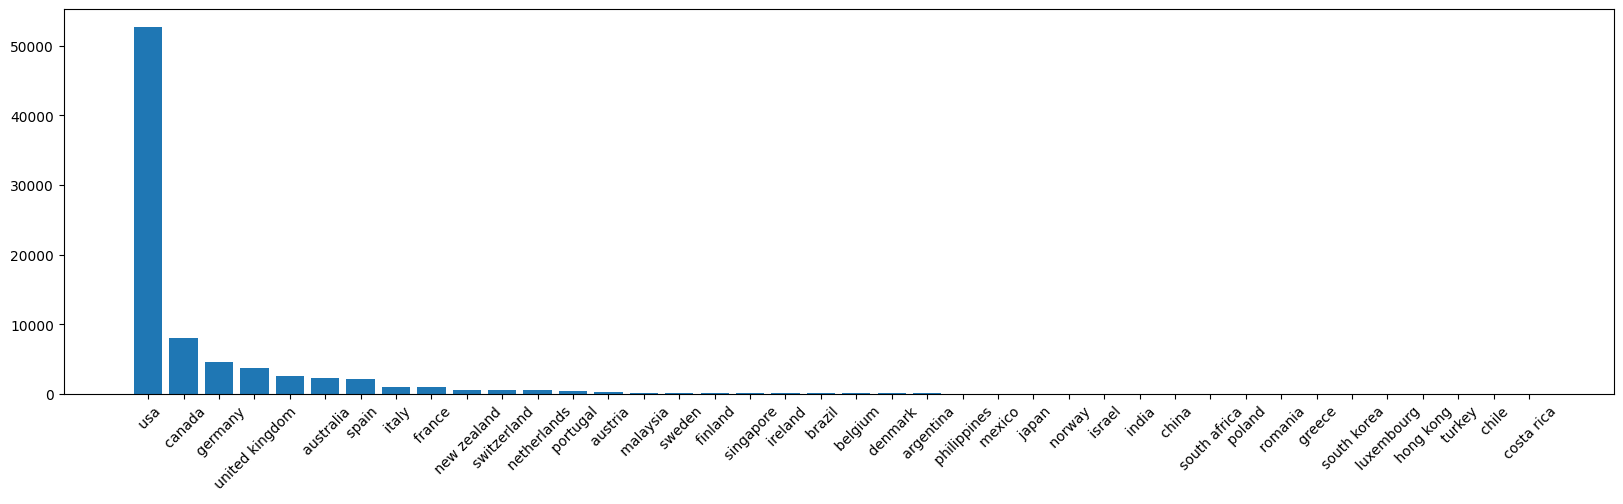

In [42]:
tmp_df = user_df['Location_country'].value_counts()[:40]
plt.figure(figsize=(20, 5))
plt.bar(x=tmp_df.index, height=tmp_df.values)
plt.xticks(rotation=45)
plt.show()

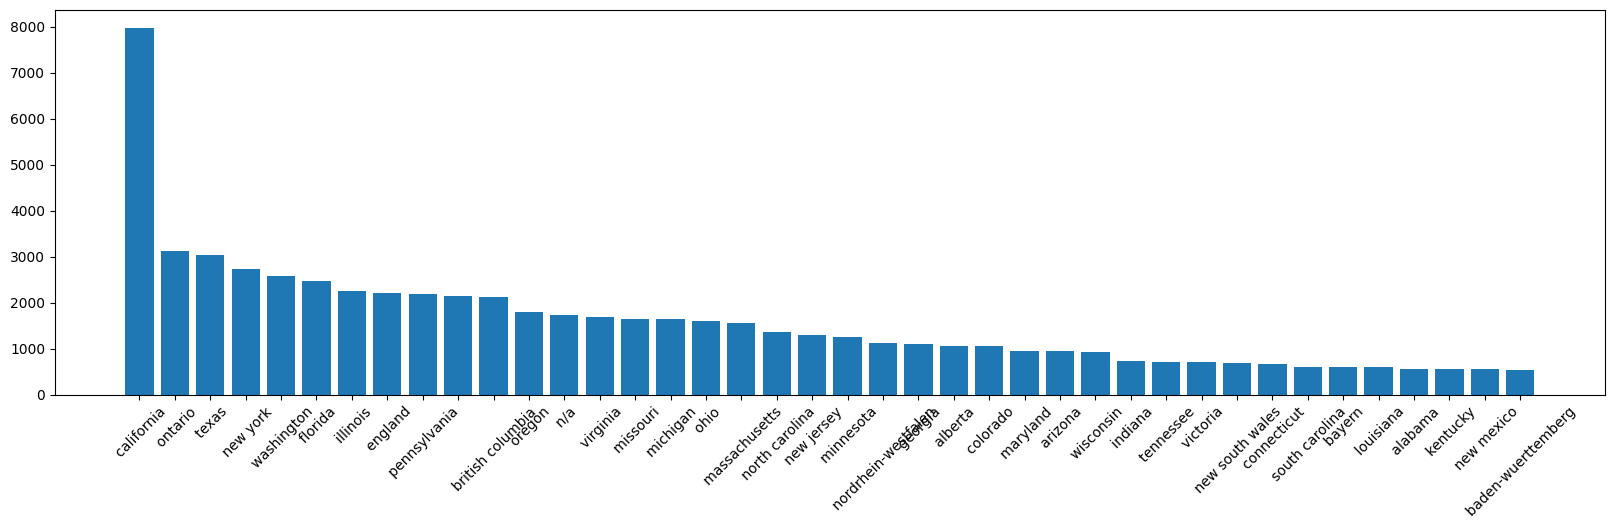

In [43]:
tmp_df = user_df['Location_city'].value_counts()[:40]
plt.figure(figsize=(20, 5))
plt.bar(x=tmp_df.index, height=tmp_df.values)
plt.xticks(rotation=45)
plt.show()

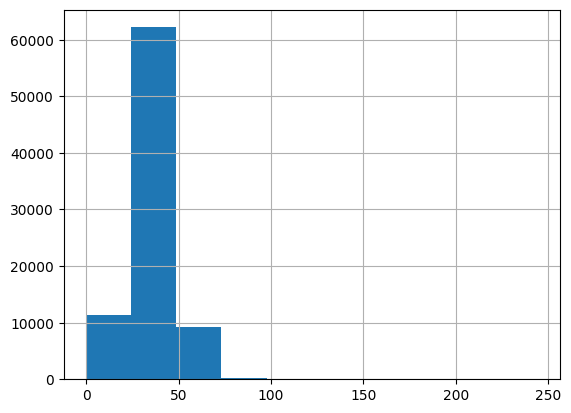

In [44]:
user_df['Age'].hist()
plt.show()

오래된 데이터의 경우, 현재 기준으로 나이를 계산하면 200살이 될 수도... 있음

# Book df

In [58]:
book_df = train_df[['Book-ID', 'Book-Title', 'Book-Author', 'Publisher', 'Year-Of-Publication']].drop_duplicates('Book-ID')
book_df.head()

,Book-ID,Book-Title,Book-Author,Publisher,Year-Of-Publication
ID,,,,,
TRAIN_000000,BOOK_044368,Road Taken,Rona Jaffe,Mira,2001.0
TRAIN_000001,BOOK_081205,Macbeth (New Penguin Shakespeare),William Shakespeare,Penguin Books,1981.0
TRAIN_000002,BOOK_086781,Waverley (Penguin English Library),Walter Scott,Penguin Books,1981.0
TRAIN_000003,BOOK_098622,Mother Earth Father Sky,Sue Harrison,Avon,1991.0
TRAIN_000004,BOOK_180810,She Who Remembers,Linda Lay Shuler,Signet Book,1989.0


In [68]:
book_df.iloc[:, :-1].describe()

,Book-ID,Book-Title,Book-Author,Publisher
count,243441,243441,243441,243441
unique,243441,217829,92635,15505
top,BOOK_044368,Selected Poems,Agatha Christie,Harlequin
freq,1,24,566,7049


labelencoding을 해도 너무 많고, tf-idf로 바꿔도 많음.

In [67]:
# # TF-IDF
# from sklearn.feature_extraction.text import TfidfVectorizer
# corpus = book_df['Book-Title'].values
# print(tfidf.fit_transform(book_df['Book-Title'].values).toarray())
# print(tfidf.vocabulary_)

In [59]:
book_df.describe()

,Year-Of-Publication
count,243441.000000
mean,1960.196676
std,256.470043
min,-1.000000
25%,1989.000000
50%,1995.000000
75%,2000.000000
max,2021.000000


In [ ]:
book_df.describe()

In [52]:
train_df[['Location', 'Book-Title', 'Book-Author', 'Publisher']].describe()

,Location,Book-Title,Book-Author,Publisher
count,871393,871393,871393,871393
unique,20971,217829,92635,15505
top,"toronto, ontario, canada",Wild Animus,Stephen King,Ballantine Books
freq,12267,2502,8467,29696


# 어떻게 해야할까?

1. User 별로 평균 평점을 구하고, item 별로 평균 평점을 구한다. 전체 평균도 구한다
2. 새로운 유저 - item 평균으로 구한다
3. 새로운 아이템 - 유저 평균으로 구한다
4. 둘 다 새로우면? - 전체 평균으로 구한다

<Axes: >

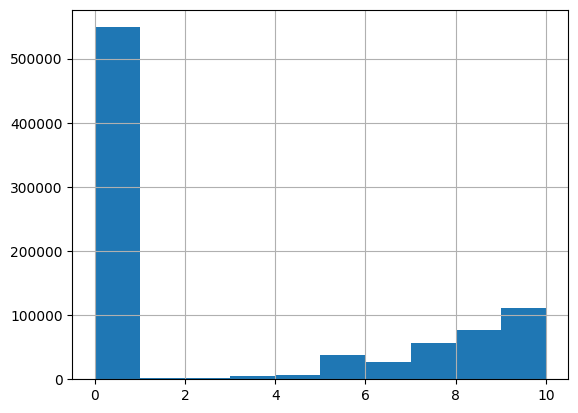

In [73]:
train_df['Book-Rating'].hist()

0이 굉..........장하다.

In [76]:
train_df['Book-Rating'].mean(), train_df['Book-Rating'].median()

(2.8205792334801862, 0.0)

In [78]:
total_avg = train_df['Book-Rating'].mean()
total_avg

2.8205792334801862

유저 평균

In [83]:
user_avg = train_df[['User-ID', 'Book-Rating']].groupby('User-ID').mean()
book_avg.head()

,Book-Rating
User-ID,
USER_00000,4.750000
USER_00001,4.000000
USER_00002,0.000000
USER_00003,5.954545
USER_00004,6.500000


array([[<Axes: title={'center': 'Book-Rating'}>]], dtype=object)

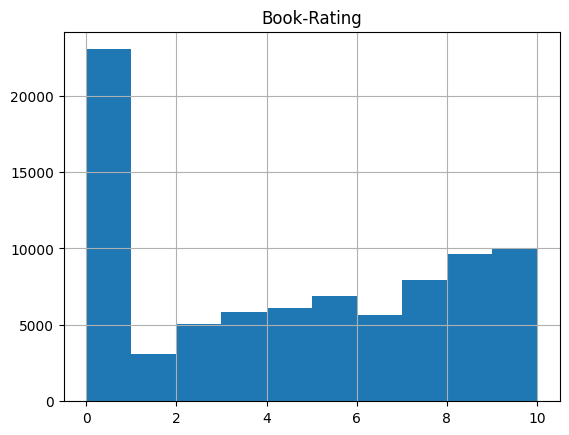

In [86]:
user_avg.hist()

In [87]:
book_avg = train_df[['Book-ID', 'Book-Rating']].groupby('Book-ID').mean()
book_avg.head()

,Book-Rating
Book-ID,
BOOK_000001,0.000000
BOOK_000002,0.000000
BOOK_000003,0.000000
BOOK_000004,1.266667
BOOK_000005,0.000000


array([[<Axes: title={'center': 'Book-Rating'}>]], dtype=object)

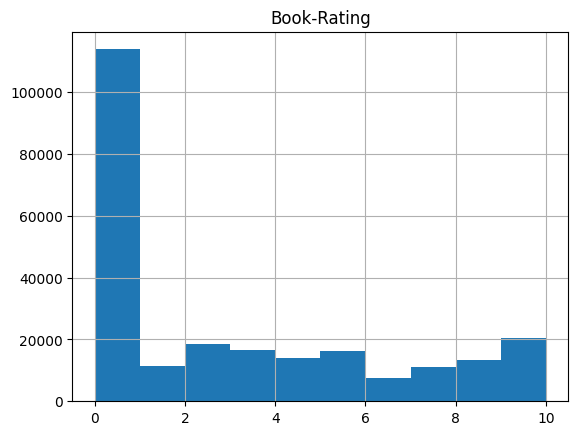

In [88]:
book_avg.hist()

In [95]:
test_ratings = []
for i, row in test_df.iterrows():
    if row['User-ID'] in user_avg:
        print('yes-user')
        rate = user_avg.loc[row['User-ID'], 'Book-Rating'].values[0]
    else:
        if row['Book-ID'] in book_avg:
            print('yes-book')
            rate = book_avg.loc[row['Book-ID'], 'Book-Rating'].values[0]
        else:
            print('no')
            rate = total_avg
    test_ratings.append(rate)

no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
n

In [97]:
np.unique(test_ratings)

array([2.82057923])

자. 모두 새로운 유저 새로운 콘텐츠다!! 위와 같은 방법으로는 절대로 추천이 불가능하다. 그럼 어떻게 해야 하는가?